In [ ]:
!pip install selenium
!pip install bs4

In [6]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException,NoAlertPresentException

import requests
from bs4 import BeautifulSoup

import pandas as pd
import re

스타벅스 매장 정보 가져오기

In [24]:
#브라우저 실행 옵션
options = webdriver.ChromeOptions()
options.add_argument("start-maximized")
driver = webdriver.Chrome(options = options)

driver.get("https://www.starbucks.co.kr")

wait = WebDriverWait(driver,10)

#1.store 버튼
store_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"#gnb > div > nav > div > ul > li.gnb_nav03 > h2 > a")))
store_button.click()

#2.매장 찾기 버튼
store_finder = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"#container > section.store_bn1_section > article > div.store_bn1_btn")))
store_finder.click()

#3.지역 검색
wait.until(EC.invisibility_of_element_located((By.CLASS_NAME, "loading_dimm")))

area_search = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"#container > div > form > fieldset > div > section > article.find_store_cont > article > header.loca_search")))
area_search.click()

#4.시도 선택
sido_finder = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"#container > div > form > fieldset > div > section > article.find_store_cont > article > header.loca_search")))
sido_finder.click()

#5.경남 선택 
gsnd_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"#container > div > form > fieldset > div > section > article.find_store_cont > article > article:nth-child(4) > div.loca_step1 > div.loca_step1_cont > ul > li:nth-child(10) > a")))
gsnd_button.click()

#6.이디야 커피 검색을 위한 시 리스트 저장
starbucks_si_list = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"#mCSB_2_container > ul")))
si_list = starbucks_si_list.text.strip().split("\n")[1:] # 0 = 전체

#7.전체 선택
gsnd_all = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"#mCSB_2_container > ul > li:nth-child(1) > a")))
gsnd_all.click()

In [ ]:
#8.매장 정보 가져오기

html = driver.page_source
soup = BeautifulSoup(html,"html.parser")

store_tags = soup.find_all("li", class_="quickResultLstCon")
len(store_tags)

starbucks_store_list = []

for store in store_tags:
    name = store['data-name']
    lat = store['data-lat']
    long = store['data-long']

    details = store.find("p",class_ = "result_details").get_text(separator="\n").strip().split("\n")
    address = details[0] if details else ""

    dong_match = re.search(r"\((.*?)\)",address)
    dong = dong_match.group(1) if dong_match else ""

    si= address.strip().split()[1]

    starbucks_store_list.append({
        "매장명":name,
        "주소": address,
        "지역": si,
        "동": dong,
        "위도": lat,
        "경도": long
    })

df_starbucks = pd.DataFrame(starbucks_store_list)
# df_starbucks.to_csv("starbucks_gsnd.csv",index=False, encoding='utf-8-sig')

driver.quit()

이디야 매장 정보 가져오기

In [87]:
#브라우저 실행 옵션

options = webdriver.ChromeOptions()
options.add_argument("start-maximized")
driver = webdriver.Chrome(options = options)

driver.get("https://www.ediya.com/")

wait = WebDriverWait(driver,10)

#1.광고 배너 삭제
try:
    # 광고 배너 존재 여부 확인
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.pop_slide_bn")))

    # onclick 스크립트 실행 (href="#c"로 URL 변경 방지)
    driver.execute_script("$('.pop_slide_bn').hide();")
    # URL에 붙은 #c 제거
    driver.execute_script("history.replaceState(null, null, window.location.pathname);")

    print("광고 닫기 완료 및 URL 정리")
except TimeoutException:
    print("광고 배너 없음 또는 이미 닫힘")


#2.매장 찾기
store_finder = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR,"li.store > a")))
store_finder.click()


#스크롤 다운 (주소 버튼이 보일 수 있도록)
time.sleep(2)
driver.execute_script("window.scrollTo(0, document.body.scrollHeight/2);")

#3.주소
address_tab = wait.until(
    EC.presence_of_element_located((By.XPATH, "//a[contains(text(),'주 소')]"))
)

driver.execute_script("arguments[0].click();",address_tab)

address_tab.click()

광고 닫기 완료 및 URL 정리


In [ ]:
#4. 시 검색 - 스타벅스 페이지에 존재하는 시 list를 가져옴
si_list = ['거제시','거창군','고성군','김해시','남해군','마산시','밀양시','사천시','산청군','양산시','의령군',
           '진주시','진해시','창녕군','창원시','통영시','하동군','함안군','함양군','합천군']
ediya_store_list = []

for si in si_list:
    # 검색어 입력
    input_box = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#keyword")))
    input_box.clear()
    input_box.send_keys(si)

    # 검색 버튼 클릭
    input_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#keyword_div > form > button")))
    input_button.click()

    # 팝업 여부 확인
    try:
        WebDriverWait(driver, 2).until(EC.alert_is_present())
        alert = driver.switch_to.alert
        print(f"[{si}] {alert.text}")
        alert.accept()
        continue
    except:
        pass  # 팝업이 없으면 매장 리스트 로드 진행

    # 매장 리스트 대기 (수정된 CSS Selector)
    try:
        stores = wait.until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#placesList > li"))
        )
        print(f"[{si}] {len(stores)}개 매장 발견")

        for store in stores:
            name = store.find_element(By.TAG_NAME, "dt").text.strip()
            address = store.find_element(By.TAG_NAME, "dd").text.strip()

            dong_match = re.search(r"\(([^,\s)]+)",address)
            dong = dong_match.group(1) if dong_match else ""

            ediya_store_list.append({
                "매장명": name, 
                "주소": address,
                "지역" : si,
                "동": dong 
            })

    except TimeoutException:
        print(f"[{si}] 매장 리스트 로딩 실패")

df_ediya = pd.DataFrame(ediya_store_list)
# df_ediya.to_csv('ediya_gsnd_원본.csv', encoding = 'utf-8-sig', index = False)

driver.quit()

[거제시] 8개 매장 발견
[거창군] 1개 매장 발견
[고성군] 3개 매장 발견
[김해시] 25개 매장 발견
[남해군] 2개 매장 발견
[마산시] 검색 결과가 없습니다.
[밀양시] 6개 매장 발견
[사천시] 5개 매장 발견
[산청군] 2개 매장 발견
[양산시] 11개 매장 발견
[의령군] 1개 매장 발견
[진주시] 23개 매장 발견
[진해시] 검색 결과가 없습니다.
[창녕군] 2개 매장 발견
[창원시] 37개 매장 발견
[통영시] 3개 매장 발견
[하동군] 2개 매장 발견
[함안군] 1개 매장 발견
[함양군] 검색 결과가 없습니다.
[합천군] 1개 매장 발견


google map api 이용

In [91]:
import os
import googlemaps
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("googlemaps_api_key")
API_KEY = api_key

gmaps = googlemaps.Client(key=API_KEY)

def get_lat_lng(address):
    try:
        geocode_result = gmaps.geocode(address)
        if geocode_result:
            location = geocode_result[0]['geometry']['location']
            return location['lat'],location['lng']
        else:
            return None,None
    except Exception as e:
        print(f"주소 변환 실패: {address},사유:{e}")
        return None,None


lat_list = []
lng_list = []

for i,addr in enumerate(df_ediya['주소']):
    lat,lng = get_lat_lng(addr)
    lat_list.append(lat)
    lng_list.append(lng)
    time.sleep(1)

df_ediya['위도'] = lat_list
df_ediya['경도'] = lng_list

df_ediya.to_csv("ediya_gsnd.csv", index=False, encoding='utf-8-sig')
print(f"저장 완료")

저장 완료


---

In [1]:
import pandas as pd
import folium

In [39]:
df_ediya = pd.read_csv('data/ediya_gsnd.csv')
df_ediya[:5]

,매장명,주소,지역,동,위도,경도
0,거제계룡점,경남 거제시 계룡로 62 (상동동),거제시,상동동,34.876262,128.626093
1,거제고현점,경남 거제시 거제중앙로29길 13 (고현동),거제시,고현동,34.891014,128.627250
2,거제고현중앙점,"경남 거제시 거제중앙로24길 13 (고현동, 도영빌딩)",거제시,고현동,34.888831,128.624414
3,거제상동점,경남 거제시 상동5길 25 (상동동),거제시,상동동,34.867485,128.635554
4,거제서정점,경남 거제시 거제면 거제남서로 3471 (서정리),거제시,서정리,34.857435,128.590080


In [40]:
df_starbucks = pd.read_csv("data/starbucks_gsnd.csv")
df_starbucks[:5]

,매장명,주소,지역,동,위도,경도
0,양산덕계DT,경상남도 양산시 웅상대로 860 (덕계동),양산시,덕계동,35.376107,129.155523
1,김해구산DT,경상남도 김해시 김해대로 1918 (구산동),김해시,구산동,35.255315,128.866384
2,김해진영DT,경상남도 김해시 진영읍 여래로20번길 34-26,김해시,NaN,35.306004,128.731753
3,신세계김해,경상남도 김해시 김해대로 2232 신세계백화점 1층,김해시,NaN,35.228483,128.873046
4,김해이마트,경상남도 김해시 김해대로 2232 김해이마트 1층,김해시,NaN,35.229997,128.872136


In [41]:
df_ediya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매장명     133 non-null    object 
 1   주소      133 non-null    object 
 2   지역      133 non-null    object 
 3   동       127 non-null    object 
 4   위도      133 non-null    float64
 5   경도      133 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.4+ KB


In [42]:
df_starbucks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매장명     81 non-null     object 
 1   주소      81 non-null     object 
 2   지역      81 non-null     object 
 3   동       60 non-null     object 
 4   위도      81 non-null     float64
 5   경도      81 non-null     float64
dtypes: float64(2), object(4)
memory usage: 3.9+ KB


In [6]:
df_starbucks[df_starbucks['동'].isnull()][:5]
#동의 값이 nan인 것은 주소 정보에 (동)이 없기 때문
# 김해구산DT경상남도 김해시 김해대로 1918 (구산동)
# 경상남도 김해시 진영읍 여래로20번길 34-26

,매장명,주소,지역,동,위도,경도
2,김해진영DT,경상남도 김해시 진영읍 여래로20번길 34-26,김해시,NaN,35.306004,128.731753
3,신세계김해,경상남도 김해시 김해대로 2232 신세계백화점 1층,김해시,NaN,35.228483,128.873046
4,김해이마트,경상남도 김해시 김해대로 2232 김해이마트 1층,김해시,NaN,35.229997,128.872136
5,김해대로DT,경상남도 김해시 김해대로 2465,김해시,NaN,35.227992,128.896545
11,김해주촌DT,경상남도 김해시 주촌면 선천로 99,김해시,NaN,35.235134,128.843383


In [7]:
df_ediya[df_ediya['동'].isnull()]

,매장명,주소,지역,동,위도,경도
8,경남거창점,경남 거창군 거창읍 강변로 119,거창군,NaN,35.684470,127.910123
10,고성간성점,강원특별자치도 고성군 간성읍 간성로 66,고성군,NaN,38.379594,128.467700
34,김해한림점,경남 김해시 한림면 김해대로 1464,김해시,NaN,35.276913,128.832175
101,부산신항점,경상남도 창원시 진해구 용원동 1343-11 드림타워 이디야커피,창원시,NaN,35.087409,128.814547
131,경남함안점,경남 함안군 가야읍 함마대로 1504,함안군,NaN,35.275449,128.400145
132,경남합천점,경남 합천군 합천읍 옥산로 34,합천군,NaN,35.568517,128.158688


In [8]:
df_starbucks.describe()

,위도,경도
count,81.000000,81.000000
mean,35.192167,128.668048
std,0.136163,0.273438
min,34.843843,128.060063
25%,35.172324,128.580956
50%,35.222674,128.684358
75%,35.249031,128.861040
max,35.485327,129.155523


In [9]:
df_ediya.describe()

,위도,경도
count,133.000000,133.000000
mean,35.250184,128.546674
std,0.411701,0.343112
min,34.781514,127.753156
25%,35.171332,128.146404
50%,35.223283,128.626093
75%,35.262188,128.814257
max,38.379594,129.157416


__이디야 고성군 중 강원도 제거__

In [43]:
df_ediya[df_ediya['지역'].str.contains('고성군',na=False)]

,매장명,주소,지역,동,위도,경도
9,경남고성점,경남 고성군 고성읍 동외로 137 (동외리),고성군,동외리,34.973523,128.325604
10,고성간성점,강원특별자치도 고성군 간성읍 간성로 66,고성군,NaN,38.379594,128.467700
11,고성경동대점,강원 고성군 토성면 봉포4길 18 (봉포리),고성군,봉포리,38.252985,128.561783


In [44]:
df_ediya = df_ediya[~df_ediya['주소'].str.contains('강원',na=False)]
df_ediya[df_ediya['지역'].str.contains('고성군',na=False)]

,매장명,주소,지역,동,위도,경도
9,경남고성점,경남 고성군 고성읍 동외로 137 (동외리),고성군,동외리,34.973523,128.325604


In [45]:
df_ediya.reset_index(drop=True)

,매장명,주소,지역,동,위도,경도
0,거제계룡점,경남 거제시 계룡로 62 (상동동),거제시,상동동,34.876262,128.626093
1,거제고현점,경남 거제시 거제중앙로29길 13 (고현동),거제시,고현동,34.891014,128.627250
2,거제고현중앙점,"경남 거제시 거제중앙로24길 13 (고현동, 도영빌딩)",거제시,고현동,34.888831,128.624414
3,거제상동점,경남 거제시 상동5길 25 (상동동),거제시,상동동,34.867485,128.635554
4,거제서정점,경남 거제시 거제면 거제남서로 3471 (서정리),거제시,서정리,34.857435,128.590080
...,...,...,...,...,...,...
126,통영죽림점,경남 통영시 광도면 죽림해안로 64-6 (죽림리),통영시,죽림리,34.885098,128.422106
127,진교하나로마트점,경남 하동군 진교면 경충로 1059 (진교리),하동군,진교리,35.031047,127.899531
128,하동군청DI점,경남 하동군 하동읍 군청로 39 (읍내리),하동군,읍내리,35.065819,127.753156
129,경남함안점,경남 함안군 가야읍 함마대로 1504,함안군,NaN,35.275449,128.400145


__1.스타벅스 vs 이디야 매장 수 비교__

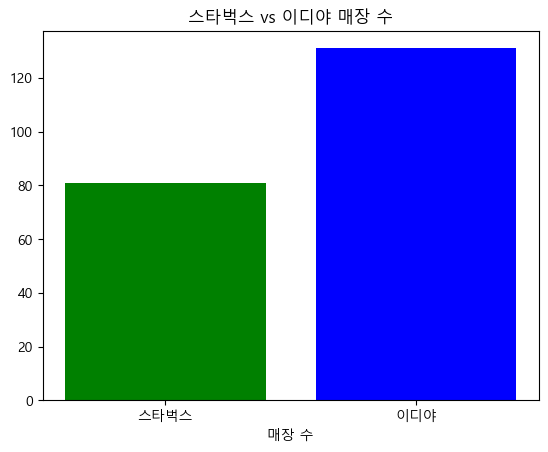

In [22]:
from font import set_korean_font
import matplotlib.pyplot as plt
set_korean_font()

counts = {
    '스타벅스':len(df_starbucks),
    '이디야':len(df_ediya)
}

plt.bar(counts.keys(),counts.values(),color=['green','blue'])
plt.title('스타벅스 vs 이디야 매장 수')
plt.xlabel('매장 수')
plt.show()

__2. 지역별 스타벅스와 이디야의 개수 차이__

In [27]:
print(df_starbucks['지역'].unique())

['양산시' '김해시' '밀양시' '사천시' '진주시' '창원시' '통영시' '거제시']


In [28]:
print(df_ediya['지역'].unique()) 
#스타벅스의 경남에 있는 시를 가져와서 비교했으나 스타벅스 8개 시도, 이디야는 17개 시도 전체에 존재

['거제시' '거창군' '고성군' '김해시' '남해군' '밀양시' '사천시' '산청군' '양산시' '의령군' '진주시' '창녕군'
 '창원시' '통영시' '하동군' '함안군' '합천군']


In [29]:
print('스타벅스:',len(df_starbucks['지역'].unique()),sep='')
print('이디야:',len(df_ediya['지역'].unique()),sep='')

스타벅스:8
이디야:17


In [29]:
starbucks_region = df_starbucks.groupby("지역").size().reset_index(name="스타벅스")
starbucks_region

,지역,스타벅스
0,거제시,6
1,김해시,17
2,밀양시,1
3,사천시,2
4,양산시,12
5,진주시,8
6,창원시,32
7,통영시,3


In [30]:
ediya_region = df_ediya.groupby("지역").size().reset_index(name='이디야')
ediya_region

,지역,이디야
0,거제시,8
1,거창군,1
2,고성군,1
3,김해시,25
4,남해군,2
5,밀양시,6
6,사천시,5
7,산청군,2
8,양산시,11
9,의령군,1


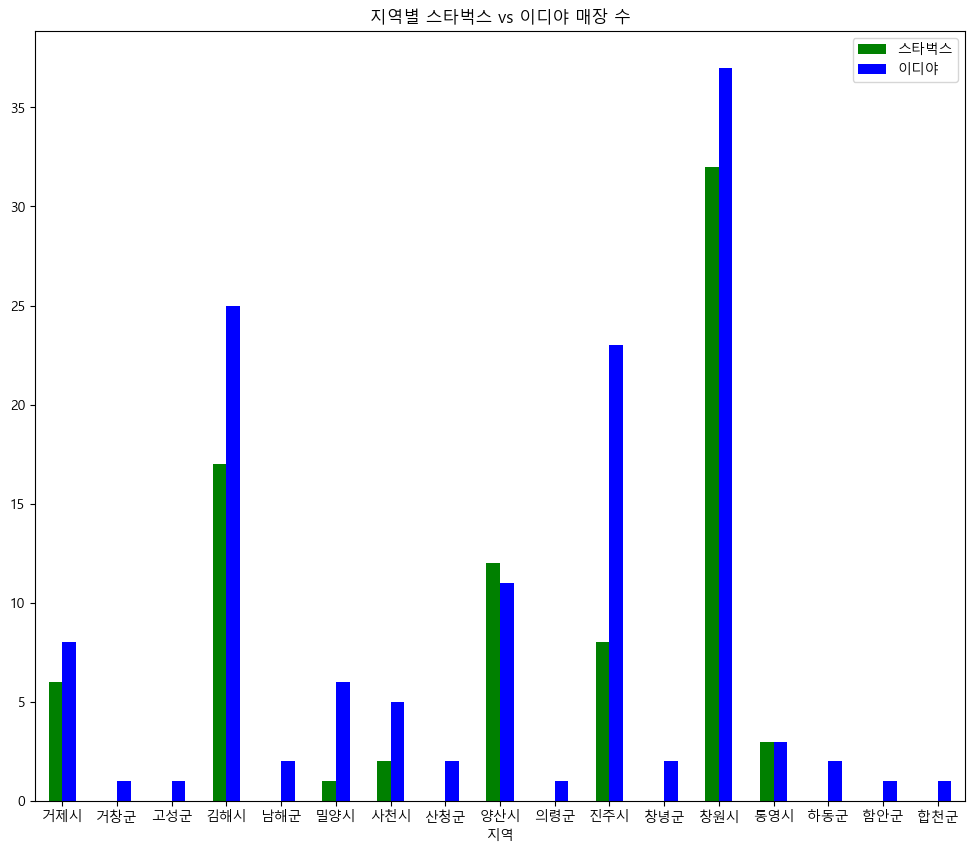

In [32]:
set_korean_font()
import matplotlib.pyplot as plt
df_region = pd.merge(starbucks_region,ediya_region, on='지역', how='outer').fillna(0)
df_region.set_index('지역').plot(kind='bar',figsize=(12,10),color = ['green','blue'])
# df_region.plot.bar(rot=0,figsize = (15,10),color=['green','blue'])
plt.title('지역별 스타벅스 vs 이디야 매장 수')   
plt.xticks(rotation = 0)                            
plt.show()

__3.동별 매장 수 집계__

In [ ]:
# df_starbucks['동'] = df_starbucks['동'].fillna('미상')
# df_ediya['동'] = df_ediya['동'].fillna('미상')

In [49]:
starbucks_dong = df_starbucks.groupby('동').size().reset_index(name='스타벅스')
starbucks_dong[:5]

,동,스타벅스
0,가음정동,1
1,가좌동,1
2,경화동,1
3,고현동,1
4,관동동,1


In [53]:
ediya_dong = df_ediya.groupby('동').size().reset_index(name='이디야')
ediya_dong[:5]

,동,이디야
0,가곡동,1
1,가좌동,2
2,가촌리,1
3,감계리,1
4,강남동,1


In [61]:
avg_star = starbucks_dong['스타벅스'].mean()
avg_ediya = ediya_dong['이디야'].mean()

print('동별 스타벅스 개수:{:.2f}'.format(avg_star))
print('동별 이디야 개수:{:.2f}'.format(avg_ediya))

동별 스타벅스 개수:1.13
동별 이디야 개수:1.31


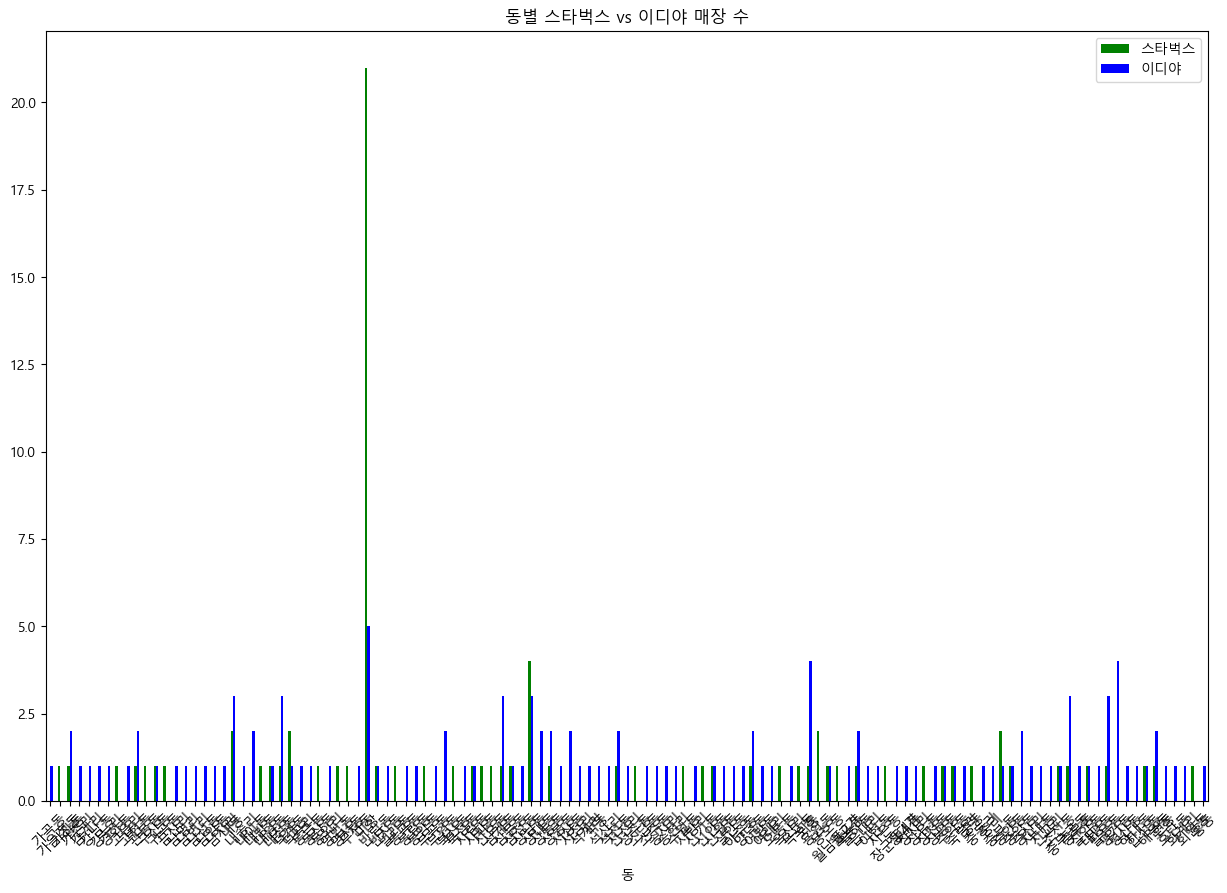

In [ ]:
df_dong = pd.merge(starbucks_dong,ediya_dong,on='동',how='outer').fillna(0)
df_dong.set_index('동').plot(kind='bar',figsize=(15,10),color=['green','blue'])
plt.title('동별 스타벅스 vs 이디야 매장 수')   
plt.xticks(rotation = 45)                            
plt.show()

__4. folium 시각화__

In [62]:
m = folium.Map(location=[35.192167,128.668048],zoom_start=8.5)

for idx,row in df_starbucks.iterrows():
    folium.CircleMarker(
        [row['위도'],row['경도']],
        radius = 3,
        color = 'red',
        fill = True,
        weight = 1,
        fill_color = 'red',
        popup=row['매장명']
    ).add_to(m)

for idx,row in df_ediya.iterrows():
    folium.CircleMarker(
        [row['위도'],row['경도']],
        radius = 3,
        color = 'blue',
        fill = True,
        weight = 1,
        fill_color = 'blue',
        popup=row['매장명']
    ).add_to(m)
m

# folium.Marker

In [64]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [67]:
from geopy.distance import geodesic

def get_nearly_starbucks(starbucks_row, df_ediya):
    starbucks_loc = (starbucks_row['위도'],starbucks_row['경도'])

    distances = df_ediya.apply(
        lambda row: geodesic(starbucks_loc,(row['위도'],row['경도'])).km,
        axis = 1
    )

    count_0_250 = (distances <=0.25).sum()
    count_250_500 = ((distances > 0.25 ) & (distances <=0.5)).sum()

    return pd.Series({
        '~250m':count_0_250,
        '250~500m':count_250_500
    }

    )

df_starbucks[['~250m','250~500m']] = df_starbucks.apply(
    lambda row: get_nearly_starbucks(row,df_ediya),axis=1
)

df_starbucks[:5]

,매장명,주소,지역,동,위도,경도,~250m,250~500m
0,양산덕계DT,경상남도 양산시 웅상대로 860 (덕계동),양산시,덕계동,35.376107,129.155523,0,0
1,김해구산DT,경상남도 김해시 김해대로 1918 (구산동),김해시,구산동,35.255315,128.866384,0,0
2,김해진영DT,경상남도 김해시 진영읍 여래로20번길 34-26,김해시,NaN,35.306004,128.731753,0,0
3,신세계김해,경상남도 김해시 김해대로 2232 신세계백화점 1층,김해시,NaN,35.228483,128.873046,0,1
4,김해이마트,경상남도 김해시 김해대로 2232 김해이마트 1층,김해시,NaN,35.229997,128.872136,1,0


In [68]:
df_starbucks.value_counts('~250m')

~250m
0    65
1    14
2     2
Name: count, dtype: int64

In [69]:
df_starbucks.value_counts('250~500m')

250~500m
0    54
1    22
2     4
4     1
Name: count, dtype: int64